<a id=top-page></a>
# `PCAfold` programming examples shown in the book chapter:

> K. Zdybał, M. R. Malik, A. Coussement, J. C. Sutherland, A. Parente, *Reduced-order modeling of reacting flows using data-driven approaches* (2022) Springer.

#### Table of contents:

- [**Computing the PCs and the PC source terms**](#demo-1)
- [**Low-dimensional manifold assessment**](#demo-2)
- [**Nonlinear regression**](#demo-3)
    - [**ANN regression**](#demo-3-1)
    - [**GPR regression**](#demo-3-2)
    - [**Kernel regression**](#demo-3-3)
    - [**Nonlinear regression assessment**](#demo-3-4)

In [1]:
from PCAfold import preprocess
from PCAfold import reduction
from PCAfold import analysis

<a id=demo-1></a>

***

## Computing the PCs and the PC source terms

[**Go to the top ↑**](#top-page)

In [2]:
import numpy as np
X = np.genfromtxt('syngas-air-SLF-state-space.csv', delimiter=',')[:,0:-1]
S = np.genfromtxt('syngas-air-SLF-state-space-sources.csv', delimiter=',')[:,0:-1]
f = np.genfromtxt('syngas-air-SLF-mixture-fraction.csv', delimiter=',')
chi = np.genfromtxt('syngas-air-SLF-dissipation-rates.csv', delimiter=',')
(n_observations, n_variables) = X.shape

In [3]:
pca = reduction.PCA(X, scaling='auto', n_components=2)

In [4]:
Z = pca.transform(X)

In [5]:
S_Z = pca.transform(S, nocenter=True)

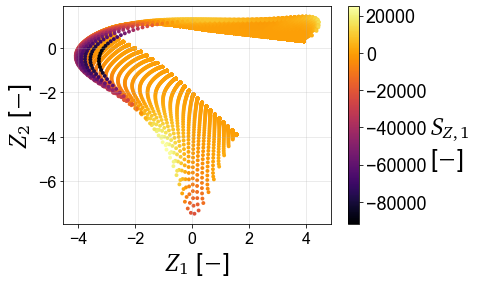

In [6]:
plt = reduction.plot_2d_manifold(Z[:,0], Z[:,1],
                                 color=S_Z[:,0],
                                 s=15,
                                 x_label='$Z_{1}$ [$-$]',
                                 y_label='$Z_{2}$ [$-$]',
                                 colorbar_label='$S_{Z, 1}$\n[$-$]',
                                 color_map='inferno',
                                 grid_on=True,
                                 figure_size=(6,4))

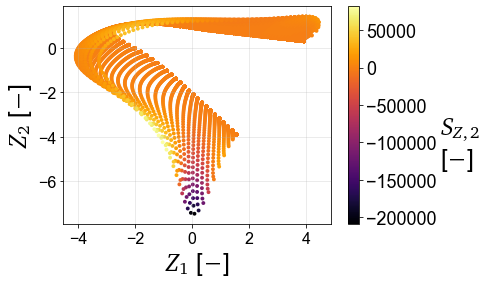

In [7]:
plt = reduction.plot_2d_manifold(Z[:,0], Z[:,1],
                                 color=S_Z[:,1],
                                 s=15,
                                 x_label='$Z_{1}$ [$-$]',
                                 y_label='$Z_{2}$ [$-$]',
                                 colorbar_label='$S_{Z, 2}$\n[$-$]',
                                 color_map='inferno',
                                 grid_on=True,
                                 figure_size=(6,4))

<a id=demo-2></a>

***

## Low-dimensional manifold assessment

[**Go to the top ↑**](#top-page)

In [8]:
variable_names=['$S_{Z,1}$', '$S_{Z,2}$']

In [9]:
bandwidth_values = np.logspace(-5, 1, 100)

In [10]:
variance_data = analysis.compute_normalized_variance(Z, S_Z, variable_names,
                                                     bandwidth_values=bandwidth_values)

<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


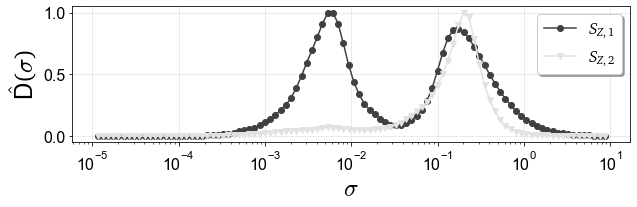

In [11]:
analysis.plot_normalized_variance_derivative(variance_data,
                                             color_map='Greys',
                                             figure_size=(10,2.5))

<a id=demo-3></a>

***

## Nonlinear regression

[**Go to the top ↑**](#top-page)

In [12]:
sample_random = preprocess.DataSampler(np.zeros((n_observations,)).astype(int), 
                                       random_seed=100, 
                                       verbose=True)
(idx_train, idx_test) = sample_random.random(80)
Z_train = Z[idx_train,:]; Z_test = Z[idx_test,:]
S_Z_train = S_Z[idx_train,:]; S_Z_test = S_Z[idx_test,:]

Cluster 0: taking 7840 train samples out of 9800 observations (80.0%).

Cluster 0: taking 1960 test samples out of 1960 remaining observations (100.0%).

Selected 7840 train samples (80.0%) and 1960 test samples (20.0%).



<a id=demo-3-1></a>

***

### ANN regression example

[**Go to the top ↑**](#top-page)

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import losses

In [14]:
model = Sequential([
Dense(5, input_dim=2, activation='sigmoid'),
Dense(5, activation='sigmoid'),
Dense(2, activation='linear')])

In [15]:
(normalized_S_Z, centers, scales) = preprocess.center_scale(S_Z, '-1to1')

In [16]:
normalized_S_Z_train = normalized_S_Z[idx_train,:]

In [17]:
model.compile(optimizers.Adam(lr=0.001), 
              loss=losses.mean_squared_error, 
              metrics=['mse'])

In [18]:
history = model.fit(Z_train, 
                    normalized_S_Z_train, 
                    batch_size=100, epochs=500, 
                    validation_split=0.2, verbose=0)

In [19]:
S_Z_ANN_predicted = model.predict(Z)
S_Z_ANN_predicted = preprocess.invert_center_scale(S_Z_ANN_predicted, 
                                                   centers, scales)

<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

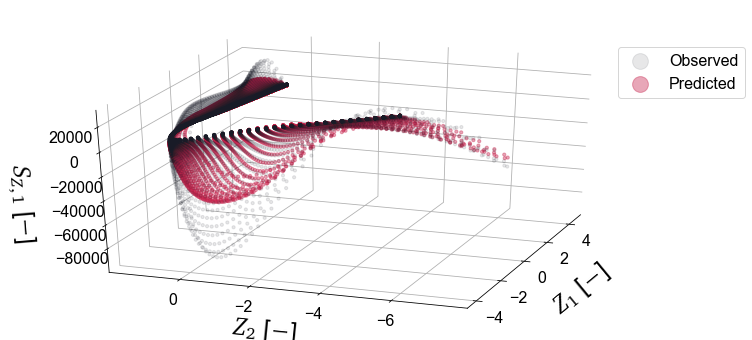

In [20]:
analysis.plot_3d_regression(Z[:,0],
                            Z[:,1],
                            S_Z[:,0],
                            S_Z_ANN_predicted[:,0],
                            elev=30,
                            azim=200,
                            x_label='$Z_1$ [$-$]',
                            y_label='$Z_2$ [$-$]',
                            z_label='$S_{Z, 1}$ [$-$]',
                            figure_size=(12,6))

<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

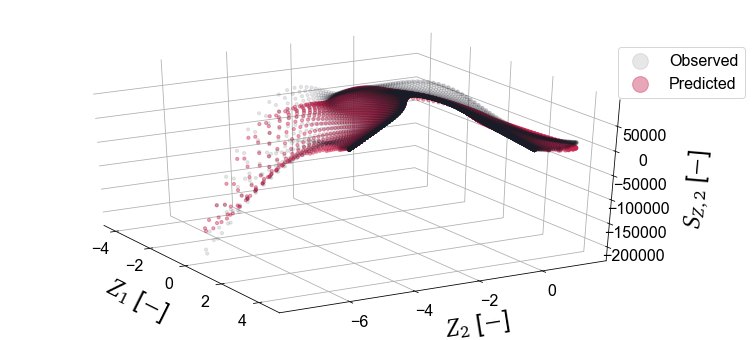

In [21]:
analysis.plot_3d_regression(Z[:,0],
                            Z[:,1],
                            S_Z[:,1],
                            S_Z_ANN_predicted[:,1],
                            elev=30,
                            azim=-30,
                            x_label='$Z_1$ [$-$]',
                            y_label='$Z_2$ [$-$]',
                            z_label='$S_{Z, 2}$ [$-$]',
                            figure_size=(12,6))

<a id=demo-3-2></a>

***

### GPR regression example

[**Go to the top ↑**](#top-page)

In [22]:
import george

In [23]:
kernel = george.kernels.ExpSquaredKernel(20, ndim=2)

In [24]:
gp = george.GP(kernel)
gp.compute(Z_train, yerr=1.25e-12,)

In [25]:
S_Z1_GPR_predicted, S_Z1_GPR_var = gp.predict(S_Z_train[:,0], Z, return_var=True)
S_Z2_GPR_predicted, S_Z2_GPR_var = gp.predict(S_Z_train[:,1], Z, return_var=True)

<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

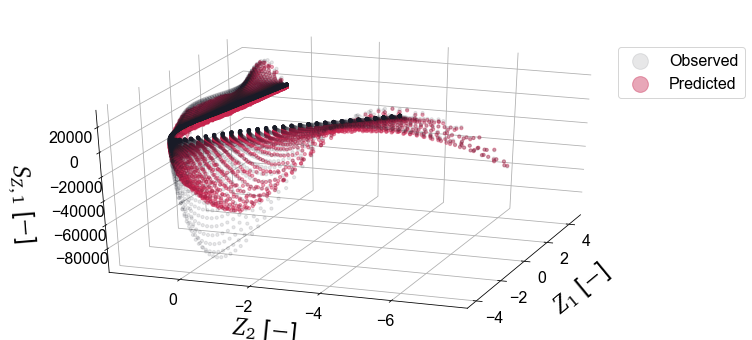

In [26]:
analysis.plot_3d_regression(Z[:,0],
                            Z[:,1],
                            S_Z[:,0],
                            S_Z1_GPR_predicted,
                            elev=30,
                            azim=200,
                            x_label='$Z_1$ [$-$]',
                            y_label='$Z_2$ [$-$]',
                            z_label='$S_{Z, 1}$ [$-$]',
                            figure_size=(12,6))

<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

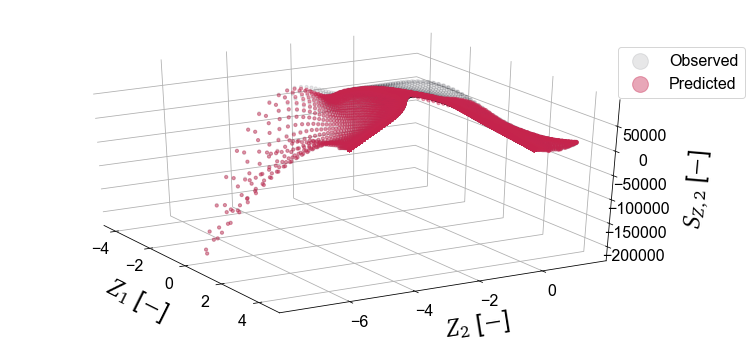

In [27]:
analysis.plot_3d_regression(Z[:,0],
                            Z[:,1],
                            S_Z[:,1],
                            S_Z2_GPR_predicted,
                            elev=30,
                            azim=-30,
                            x_label='$Z_1$ [$-$]',
                            y_label='$Z_2$ [$-$]',
                            z_label='$S_{Z, 2}$ [$-$]',
                            figure_size=(12,6))

<a id=demo-3-3></a>

***

### Kernel regression example

[**Go to the top ↑**](#top-page)

In [28]:
bandwidth = 0.5

In [29]:
model = analysis.KReg(Z_train, S_Z_train)

In [30]:
S_Z_KReg_predicted = model.predict(Z, bandwidth=bandwidth)

<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

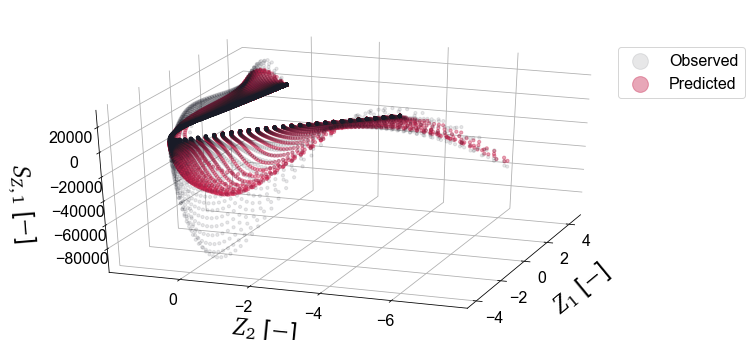

In [31]:
analysis.plot_3d_regression(Z[:,0],
                            Z[:,1],
                            S_Z[:,0],
                            S_Z_KReg_predicted[:,0],
                            elev=30,
                            azim=200,
                            x_label='$Z_1$ [$-$]',
                            y_label='$Z_2$ [$-$]',
                            z_label='$S_{Z, 1}$ [$-$]',
                            figure_size=(12,6))

<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

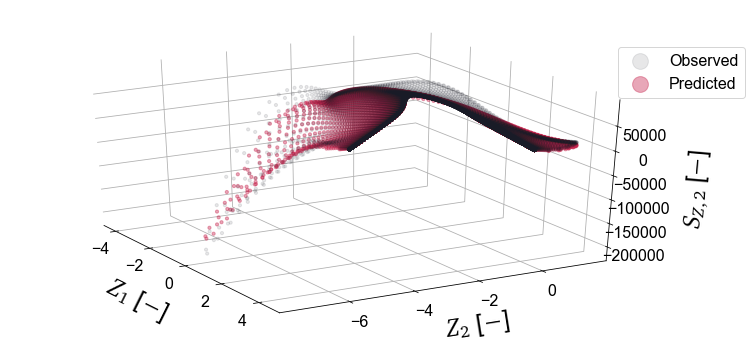

In [32]:
analysis.plot_3d_regression(Z[:,0],
                            Z[:,1],
                            S_Z[:,1],
                            S_Z_KReg_predicted[:,1],
                            elev=30,
                            azim=-30,
                            x_label='$Z_1$ [$-$]',
                            y_label='$Z_2$ [$-$]',
                            z_label='$S_{Z, 2}$ [$-$]',
                            figure_size=(12,6))

<a id=demo-3-4></a>

***

### Nonlinear regression assessment

[**Go to the top ↑**](#top-page)

In [33]:
metrics = analysis.RegressionAssessment(S_Z,
                                        S_Z_KReg_predicted,
                                        variable_names=variable_names,
                                        norm='std',
                                        tolerance=0.05)

In [34]:
metrics.print_metrics(table_format=['pandas'], metrics=['R2', 'NRMSE', 'GDE'])

,R2,NRMSE,GDE
"$S_{Z,1}$",0.4800,0.7211,45.2449
"$S_{Z,2}$",0.8100,0.4358,45.2449


In [35]:
(idx, _) = preprocess.predefined_variable_bins(S_Z[:,0], 
                                               split_values=[-10000, 0, 10000],
                                               verbose=False)

<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/spitfire/lib/python3.7/site-packages/matplotlib/pyplot.py'>

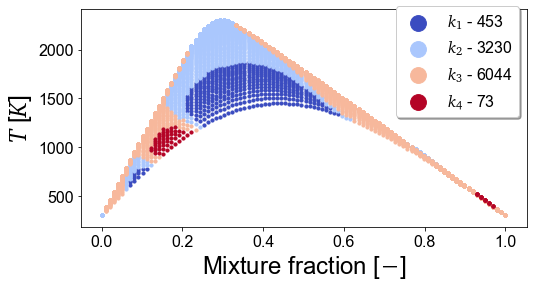

In [36]:
preprocess.plot_2d_clustering(f,
                              X[:,0],
                              idx,
                              x_label='Mixture fraction [$-$]',
                              y_label='$T$ [$K$]',
                              first_cluster_index_zero=False,
                              color_map='coolwarm',
                              figure_size=(8,4))

In [37]:
metrics = analysis.RegressionAssessment(S_Z[:,0], S_Z_KReg_predicted[:,0], 
                                        idx=idx,
                                        use_global_mean=True,
                                        norm='std',
                                        use_global_norm=True)

In [38]:
metrics.print_stratified_metrics(table_format=['pandas'], metrics=['NRMSE'])

,Observations,Min,Max,NRMSE
k1,453,"-91,760.3782","-10,016.6359",3.0987
k2,3230,"-9,989.6371",-0.0000,0.4287
k3,6044,0.0000,"9,965.7716",0.1419
k4,73,"10,002.6112","24,987.7263",0.6479


***